# Xử lý dữ liệu StreamSpot
## Thông tin về dataset
Dataset StreamSpot là một dataset bao gồm các cạnh của khoảng 600 cuộc tấn công được để trong 1 file .tsv với các cột như sau

```
source-id	source-type	destination-id	destination-type	edge-type	graph-id
```

In [12]:
import pandas as pd
import numpy as np
import hashlib
import networkx as nx
from collections import Counter, deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import random as rd

## Tiền xử lý


In [ ]:
# Copyright 2016 Emaad Ahmed Manzoor
# License: Apache License, Version 2.0
# https://github.com/sbustreamspot/sbustreamspot-data/

import sys
remap = {
    'process': 'a',
    'thread': 'b',
    'file': 'c',
    'MAP_ANONYMOUS': 'd',
    'NA': 'e',
    'stdin': 'f',
    'stdout': 'g',
    'stderr': 'h',
    'accept': 'i',
    'access': 'j',
    'bind': 'k',
    'chmod': 'l',
    'clone': 'm',
    'close': 'n',
    'connect': 'o',
    'execve': 'p',
    'fstat': 'q',
    'ftruncate': 'r',
    'listen': 's',
    'mmap2': 't',
    'open': 'u',
    'read': 'v',
    'recv': 'w',
    'recvfrom': 'x',
    'recvmsg': 'y',
    'send': 'z',
    'sendmsg': 'A',
    'sendto': 'B',
    'stat': 'C',
    'truncate': 'D',
    'unlink': 'E',
    'waitpid': 'F',
    'write': 'G',
    'writev': 'H',
}
rmap = {v: k for k, v in remap.items()}
fo = open("attack.csv", "w")
gcnt = 0
if __name__ == "__main__":
    with open('all.tsv', 'r') as f:
        prev_src_id = ""
        prev_dst_id = ""
        prev_e_type = ""
        prev_graph_id = ""
        for line in tqdm(f):
            fields = [w.strip() for w in line.split('\t')]
            fields[0] = str(int(fields[0]) + 1)
            fields[1] = rmap[fields[1]]
            fields[2] = str(int(fields[2]) + 1)
            fields[3] = rmap[fields[3]]
            fields[4] = rmap[fields[4]]
            fields[5] = str(int(fields[5]) + 1)
            if prev_graph_id != fields[5]:
                gcnt += 1
            if(gcnt < 300 or gcnt > 399):
                fields.append("benign")
            else:
                fields.append("attack")

            # avoid parallel edges from block-based file reads
            if fields[0] == prev_src_id and \
               fields[2] == prev_dst_id and \
               fields[4] == prev_e_type and \
               fields[5] == prev_graph_id:
                continue
            prev_src_id = fields[0]
            prev_dst_id = fields[2]
            prev_e_type = fields[4]
            prev_graph_id = fields[5]

            # del fields[5]  # no timestamp
            #print('\t'.join(fields))  # <-- Python 3 style print
            if(gcnt >= 300 and gcnt <= 399):
                fo.write(','.join(fields))
                fo.write('\n')


## Chuyển file đã tiền xử lý sang dạng để sử dụng cho WL subtree

In [2]:

data_path = "processed2.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError("Please upload the 'streamspot_sample.csv' file again.")

print("Reading CSV data...")
df = pd.read_csv(data_path, header=None,
                 names=['src', 'src_type', 'dst', 'dst_type', 'edge_type', "graph_id", "class"])

# Build graphs and extract labels
print("Building graphs...")
graphs = []
labels = []
label = ""
grouped = df.groupby("graph_id")
for graph_id, group in tqdm(grouped, desc="Graphs"):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        label = row["class"]
        G.add_node(row["src"], label=row["src_type"])
        G.add_node(row["dst"], label=row["dst_type"])
        G.add_edge(row["src"], row["dst"], label=row["edge_type"])
    graphs.append(G)
    labels.append(label)

print(labels)

Reading CSV data...
Building graphs...


Graphs: 100%|██████████| 600/600 [1:09:47<00:00,  6.98s/it]

['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign',

In [5]:
joblib.dump((graphs, labels), "graphs_and_labels.joblib")


['graphs_and_labels.joblib']

In [2]:
graphs, labels = joblib.load("graphs_and_labels.joblib")

## FlexSketch
Được trình bày trong bài báo [FlexSketch: Estimation of Probability Density for Stationary and Non-Stationary Data Streams](https://doi.org/10.3390/s21041080).

FlexSketch được sử dụng

In [3]:
class FlexSketch:
    def __init__(self, max_bins=100, max_histograms=5):
        self.max_bins = max_bins
        self.max_histograms = max_histograms
        self.histograms = deque()
        self.weights = deque()

    def update(self, label_counter):
        most_common = label_counter.most_common(self.max_bins)
        vector = np.zeros(self.max_bins)
        for i, (_, count) in enumerate(most_common):
            vector[i] = count
        self.histograms.append(vector)
        self.weights.append(1.0)
        if len(self.histograms) > self.max_histograms:
            self.histograms.popleft()
            self.weights.popleft()
        total_weight = sum(self.weights)
        self.weights = deque([w / total_weight for w in self.weights])

    def estimate_vector(self):
        result = np.zeros(self.max_bins)
        for h, w in zip(self.histograms, self.weights):
            result += w * h
        return result

# WL subtree extraction
def wl_subtree_features(graph, k=2):
    node_labels = nx.get_node_attributes(graph, 'label')
    features = {node: [node_labels.get(node, 'N/A')] for node in graph.nodes()}
    current_labels = node_labels.copy()
    for _ in range(k):
        new_labels = {}
        for node in graph.nodes():
            neighbors = sorted(
                [str(current_labels.get(nbr, '')) for nbr in graph.predecessors(node)] +
                [str(current_labels.get(nbr, '')) for nbr in graph.successors(node)]
            )
            combined = str(current_labels.get(node, '')) + "|" + "|".join(neighbors)
            hash_label = hashlib.md5(combined.encode()).hexdigest()
            new_labels[node] = hash_label
            features[node].append(hash_label)
        current_labels = new_labels
    return features

In [4]:
print("Extracting FlexSketch vectors...")
flex_vectors = []
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch = FlexSketch(max_bins=100)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())



Extracting FlexSketch vectors...


Vectorizing: 100%|██████████| 600/600 [00:29<00:00, 20.48it/s]


Splitting benign and attack samples...
Standardizing feature vectors...
Training KMeans on benign samples...
Computing anomaly threshold...


Benign distances: 100%|██████████| 500/500 [00:00<00:00, 118805.35it/s]


Predicting anomalies...


Predicting: 100%|██████████| 550/550 [00:00<00:00, 158514.89it/s]

Evaluating...


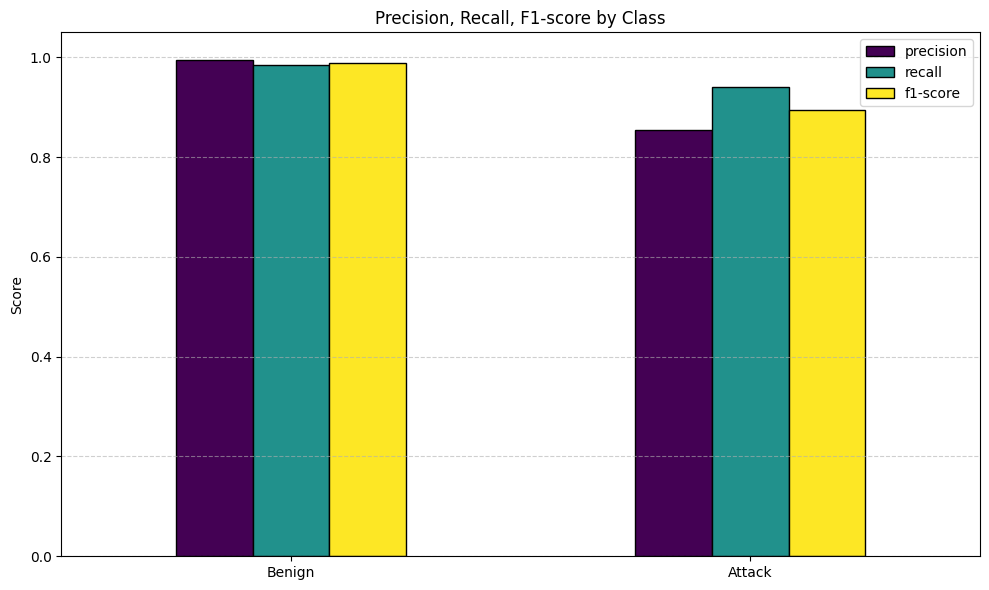


=== Classification Report (Anomaly Detection) ===
{'Benign': {'precision': 0.9939393939393939, 'recall': 0.984, 'f1-score': 0.9889447236180905, 'support': 500.0}, 'Attack': {'precision': 0.8545454545454545, 'recall': 0.94, 'f1-score': 0.8952380952380953, 'support': 50.0}, 'accuracy': 0.98, 'macro avg': {'precision': 0.9242424242424242, 'recall': 0.962, 'f1-score': 0.9420914094280929, 'support': 550.0}, 'weighted avg': {'precision': 0.9812672176308539, 'recall': 0.98, 'f1-score': 0.9804259392199091, 'support': 550.0}}


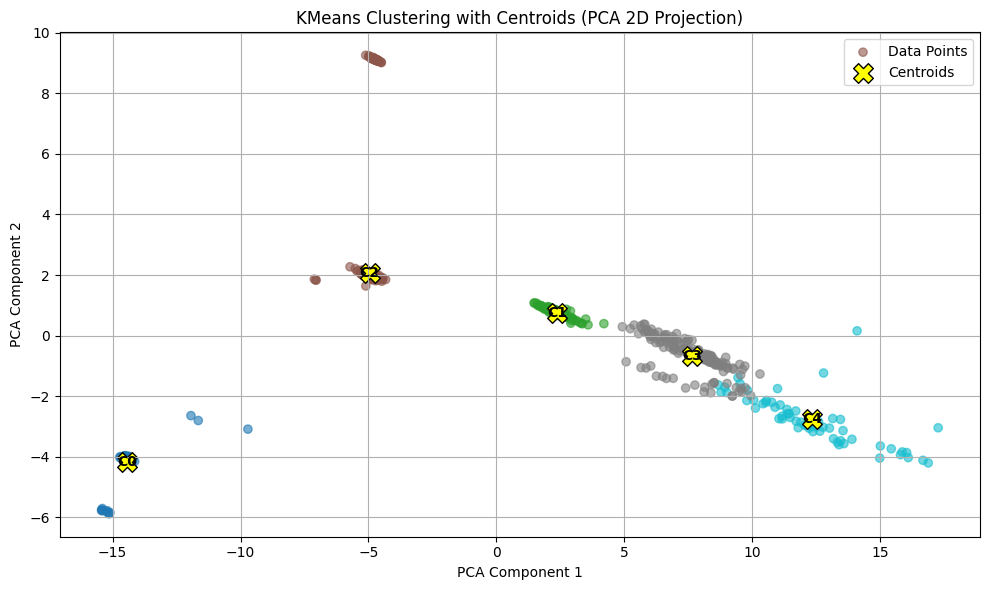

In [58]:
X = np.array(flex_vectors)
y = np.array(labels)

print("Splitting benign and attack samples...")
X_benign = X[y == "benign"]
X_attack = X[y == "attack"]
X_attack = rd.choices(X_attack, k = 50)
y_attack = ["attack"] * 50

X = np.concatenate([X_benign, X_attack], axis=0)
y = ["benign"] * 500 + ["attack"] * 50
print("Standardizing feature vectors...")
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
#X_attack_scaled = scaler.transform(X_attack)
X_all_scaled = scaler.transform(X)

print("Training KMeans on benign samples...")
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_benign_scaled)

def min_distance(x):
    return np.min(np.linalg.norm(kmeans.cluster_centers_ - x, axis=1))

print("Computing anomaly threshold...")
benign_dists = [min_distance(x) for x in tqdm(X_benign_scaled, desc="Benign distances")]
threshold = np.percentile(benign_dists, 98.5)

print("Predicting anomalies...")
all_labels = [1 if cls == "attack" else 0 for cls in y]
pred_labels = [1 if min_distance(x) > threshold else 0 for x in tqdm(X_all_scaled, desc="Predicting")]

print("Evaluating...")
report = classification_report(all_labels, pred_labels, target_names=["Benign", "Attack"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Filter only Benign, Attack
plot_data = df_report.loc[["Benign", "Attack"], ["precision", "recall", "f1-score"]]

# Plot
ax = plot_data.plot(kind="bar", figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

model_path = "kmeans_model.joblib"
scaler_path = "scaler.joblib"

joblib.dump(kmeans, model_path)
joblib.dump(scaler, scaler_path)

print("\n=== Classification Report (Anomaly Detection) ===")
print(report)
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Predict cluster labels for visualization
cluster_labels = kmeans.predict(X_all_scaled)

# Plot clusters with centroids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, label="Data Points")
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='yellow', marker='X', s=200, edgecolor='black', label="Centroids")

# Annotate centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'C{i}', fontsize=10, ha='center', va='center', weight='bold', color='black')

plt.title("KMeans Clustering with Centroids (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Thử nghiệm trên input thực tế

In [7]:
data_path = "attack.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError("Please upload the 'streamspot_sample.csv' file again.")

print("Reading CSV data...")
df = pd.read_csv(data_path, header=None,
                 names=['src', 'src_type', 'dst', 'dst_type', 'edge_type', "graph_id", "class"])

# Build graphs and extract labels
print("Building graphs...")
graphs = []
labels = []
label = ""
grouped = df.groupby("graph_id")
count = 0
for graph_id, group in tqdm(grouped, desc="Graphs"):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        label = row["class"]
        G.add_node(row["src"], label=row["src_type"])
        G.add_node(row["dst"], label=row["dst_type"])
        G.add_edge(row["src"], row["dst"], label=row["edge_type"])
    graphs.append(G)
    labels.append(label)

print(labels)

flex_vectors = []
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch = FlexSketch(max_bins=100)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())

total = 0

def detect(x):
    global total
    dist = min_distance(x)
    print(dist)
    total += dist
    print(threshold)
    return dist > threshold

X = np.array(flex_vectors)
y = np.array(labels)
Xscale = scaler.transform(X)
for G in Xscale:

    if detect(G):
        print("attack")

    else:
        print("benign")

    break

print(total / len(flex_vectors))



Reading CSV data...
Building graphs...


Graphs: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


['attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack']

Vectorizing: 100%|██████████| 100/100 [00:05<00:00, 19.11it/s]

70.4042816699072
6.185350915651964
attack
0.7040428166990721
0.7727738869210431
0.8733612738530497
0.6054759757682938
0.8396312250481187
0.5694444221963099
0.786603307287878
0.6241759088643157
0.5492028763010379
0.6664188620270279
1.3324577320577327
0.5176810221727383
0.6613965237788096
0.6788282314593265
0.49743092955495816
0.5610068254122648
0.47350082618477946
0.4999702005292548
0.5356195071253357
0.41755168477716076
0.7243369237406112
0.9358571065422788
1.1699780118602086
1.0060745799078687
0.6736287496507452
0.8669119512508526
0.6403769358632501
0.5645568869195167
0.6854260987637434
0.5725429909915596
0.6231118420645617
0.50090823063489
0.7475613379546189
0.6223779586371324
0.4872867891493932
0.5433337736789933
0.8707382469361421
0.5562683579580756
0.5465029586273816
0.7182887819225667
0.5622386816478412
0.7020804572236005
0.5366749961420016
0.4751436882987236
0.5086505010460746
0.5502220799011094
0.7280256879705946
0.9502404412151951
0.46382918819776325
1.330084259981709
0.548400

In [9]:
def detect(x):
    dist = min_distance(x)
    return dist > threshold
X = np.array(flex_vectors)
y = np.array(labels)
X_benign = X[y == "benign"]
X_attack = X[y == "attack"]
Xscale = scaler.transform(X_attack)
total = 0
be = 0
at = 0
for G in Xscale:
    total += 1
    if detect(G):
        print("attack")
        at += 1
    else:
        print("benign")
        be += 1

print(at, be, be/total)



benign
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
benign
attack
benign
benign
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
benign
attack
attack
attack
attack
benign
attack
attack
attack
attack
attack
attack
attack
attack
attack
attack
94 6 0.06
